# Step 1. Integrate public and disease-specific datasets to train TriMap

Applying AI to biological questions often hinges on the availability of large, high-quality datasets. However, in many immunological contexts, such as modeling TCR–peptide–HLA (T-P-H) interactions, data are extremely limited, both in scale and specificity. As a result, models trained on one dataset often fail to generalize across diseases.

In this study, we demonstrate that integrating minimal task-specific data and large-scale data from unrelated diseases (e.g., viral infections) can significantly enhance model performance on a new disease. Specifically, we show that with just 39 peptides and 5 TCR binding measurements from ankylosing spondylitis (AS) patients, the model’s performance on AS-related prediction tasks improves from ineffective to highly usable. This approach highlights a promising strategy to overcome data scarcity in disease-specific TCR modeling.

## Load required libraries

In [30]:
import pandas as pd
from trimap import utils
from trimap.model import TCRbind
import torch
import numpy as np

import warnings
warnings.filterwarnings("ignore")

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load training and validation datasets

The TCR sequences should be in the form of CDR3 regions, and the V and J gene information should be provided separately. **All V and J genes should be in the Allele column of the trajs_aa.tsv, trajs_aa.tsv, trbjs_aa.tsv, and trbjs_aa.tsv.** in the 'library/' folder.

### Load the large-scale public VDJdb dataset
[Download VDJdb.csv](https://drive.google.com/file/d/1TpgkOJunKct8KJ43ntYFjGjhs6W92vrI/view?usp=drive_link)

In [31]:
df_train = pd.read_csv('VDJdb.csv')
print(df_train.iloc[0])

alpha                                                  CIVRAPGRADMRF
beta                                            CASSYLPGQGDHYSNQPQHF
HLA                                                      HLA-B*08:01
Epitope                                                     FLKEKGGL
Epitope species                                                HIV-1
MHC class                                                       MHCI
V_alpha                                                  TRAV26-1*01
J_alpha                                                    TRAJ43*01
V_beta                                                     TRBV13*01
J_beta                                                    TRBJ1-5*01
Species                                                  HomoSapiens
Score                                                              2
Method             {"frequency": "", "identification": "tetramer-...
Name: 0, dtype: object


### Reconstruct full TCR sequences by CDR3 and VJ gene information

In [32]:
df_train['alpha'] = utils.determine_tcr_seq_vj(df_train['alpha'].tolist(), df_train['V_alpha'].tolist(), df_train['J_alpha'].tolist(), chain='A')
df_train['beta'] = utils.determine_tcr_seq_vj(df_train['beta'].tolist(), df_train['V_beta'].tolist(), df_train['J_beta'].tolist(), chain='B')
df_train = df_train[['alpha', 'beta', 'V_alpha', 'J_alpha', 'V_beta', 'J_beta', 'HLA', 'Epitope']]
print(df_train.iloc[0])

alpha      DAKTTQPPSMDCAEGRAANLPCNHSTISGNEYVYWYRQIHSQGPQY...
beta       AAGVIQSPRHLIKEKRETATLKCYPIPRHDTVYWYQQGPGQDPQFL...
V_alpha                                          TRAV26-1*01
J_alpha                                            TRAJ43*01
V_beta                                             TRBV13*01
J_beta                                            TRBJ1-5*01
HLA                                              HLA-B*08:01
Epitope                                             FLKEKGGL
Name: 0, dtype: object


### Load a small amount of disease-specific data
Experimentally validated immmunogenic peptides from yeast display that can be presented by HLA-B27 and activate TRBV9 T cells. [Download AS_synthetic.csv](https://drive.google.com/file/d/11ORwPiw8GHVQtVGzyqLikq1Qm6Cblbk6/view?usp=drive_link)

In [33]:
AS_synthetic = pd.read_csv('AS_synthetic.csv')
AS_synthetic['alpha'] = utils.determine_tcr_seq_vj(AS_synthetic['alpha'].tolist(), AS_synthetic['V_alpha'].tolist(), AS_synthetic['J_alpha'].tolist(), chain='A')
AS_synthetic['beta'] = utils.determine_tcr_seq_vj(AS_synthetic['beta'].tolist(), AS_synthetic['V_beta'].tolist(), AS_synthetic['J_beta'].tolist(), chain='B')
print(AS_synthetic.iloc[0])

Epitope                                            SRIMLLAPK
alpha      KQEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTS...
beta       DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFL...
HLA                                              HLA-B*27:05
label                                                      1
V_alpha                                            TRAV21*01
J_alpha                                            TRAJ21*01
V_beta                                              TRBV9*01
J_beta                                            TRBJ2-3*01
Name: 0, dtype: object


### Load validation data
Experimentally validated eptiopes from microbial strains or human proteins that can be presented by HLA-B27 and activate TRBV9 T cells. [Download AS_natural.csv](https://drive.google.com/file/d/1H4D_tviX2uyPU-puHxBPeZe-GmxQHQG0/view?usp=drive_link)

In [34]:
AS_natural = pd.read_csv('AS_natural.csv')
AS_natural['alpha'] = utils.determine_tcr_seq_vj(AS_natural['alpha'].tolist(), AS_natural['V_alpha'].tolist(), AS_natural['J_alpha'].tolist(), chain='A')
AS_natural['beta'] = utils.determine_tcr_seq_vj(AS_natural['beta'].tolist(), AS_natural['V_beta'].tolist(), AS_natural['J_beta'].tolist(), chain='B')
print(AS_natural.iloc[0])

alpha           KQEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTS...
beta            DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFL...
V_alpha                                                 TRAV21*01
J_alpha                                                 TRAJ28*01
V_beta                                                   TRBV9*01
J_beta                                                 TRBJ2-3*01
HLA                                                   HLA-B*27:05
Name                                                        AS3.1
Epitope                                                 TRLALIAPK
Epitope_name                                                PRPF3
label                                                           1
Name: 0, dtype: object


```{warning}
**Note on model usage and evaluation**

For validation purposes, we currently split the available data into training and testing sets. However, in real-world applications, **both** `AS_synthetic.csv` and `AS_natural.csv` should be included in the training set to achieve better predictive performance.

In addition, to mitigate potential variance due to random initialization, we recommend training the model under **10 different random seeds** and aggregating the predictions from all runs (e.g., via ensembling) to obtain more stable and reliable results.


## Training and saving the model

Train the model using the integrated dataset, which includes both the large-scale public VDJdb data and the small disease-specific data.

In [6]:
THEmodel = TCRbind().to(device)
THEmodel.train_model(df_train, df_add=AS_synthetic, num_epochs=20, device=device, phla_model_dir='phla_model.pt')
torch.save(THEmodel.state_dict(), 'TriMap_model_AS.pth')

INFO:trimap.model:Training...
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:trimap.model:Loading alpha_dict.pt
INFO:trimap.model:Found new alpha sequences, embedding...
100%|██████████| 3/3 [00:10<00:00,  3.59s/it]
INFO:trimap.model:Updated and saved alpha_dict.pt
INFO:trimap.model:Loading beta_dict.pt
INFO:trimap.model:Found new beta sequences, embedding...
100%|██████████| 3/3 [00:10<00:00,  3.63s/it]
INFO:trimap.model:Updated and saved beta_dict.pt
100%|██████████| 308/308 [01:45<00:00,  2.92it/s]


Epoch [1/20], Loss: 0.6157, ROC: 0.6784


100%|██████████| 308/308 [01:45<00:00,  2.91it/s]


Epoch [2/20], Loss: 0.5217, ROC: 0.7485


100%|██████████| 308/308 [01:56<00:00,  2.64it/s]


Epoch [3/20], Loss: 0.5745, ROC: 0.7776


100%|██████████| 309/309 [01:47<00:00,  2.87it/s]


Epoch [4/20], Loss: 0.4475, ROC: 0.7931


100%|██████████| 309/309 [01:39<00:00,  3.12it/s]


Epoch [5/20], Loss: 0.5160, ROC: 0.8059


100%|██████████| 308/308 [01:51<00:00,  2.77it/s]


Epoch [6/20], Loss: 0.4794, ROC: 0.8168


100%|██████████| 309/309 [01:48<00:00,  2.86it/s]


Epoch [7/20], Loss: 0.4577, ROC: 0.8276


100%|██████████| 309/309 [01:52<00:00,  2.75it/s]


Epoch [8/20], Loss: 0.4871, ROC: 0.8352


100%|██████████| 309/309 [01:51<00:00,  2.76it/s]


Epoch [9/20], Loss: 0.5085, ROC: 0.8454


100%|██████████| 309/309 [01:49<00:00,  2.83it/s]


Epoch [10/20], Loss: 0.4639, ROC: 0.8528


100%|██████████| 309/309 [01:43<00:00,  3.00it/s]


Epoch [11/20], Loss: 0.4757, ROC: 0.8632


100%|██████████| 308/308 [01:49<00:00,  2.82it/s]


Epoch [12/20], Loss: 0.3130, ROC: 0.8732


100%|██████████| 308/308 [01:32<00:00,  3.33it/s]


Epoch [13/20], Loss: 0.4456, ROC: 0.8788


100%|██████████| 309/309 [01:45<00:00,  2.94it/s]


Epoch [14/20], Loss: 0.3144, ROC: 0.8864


100%|██████████| 308/308 [01:33<00:00,  3.28it/s]


Epoch [15/20], Loss: 0.4011, ROC: 0.8964


100%|██████████| 308/308 [01:38<00:00,  3.12it/s]


Epoch [16/20], Loss: 0.3377, ROC: 0.9012


100%|██████████| 309/309 [01:42<00:00,  3.01it/s]


Epoch [17/20], Loss: 0.3542, ROC: 0.9097


100%|██████████| 308/308 [01:39<00:00,  3.08it/s]


Epoch [18/20], Loss: 0.3387, ROC: 0.9179


100%|██████████| 308/308 [01:38<00:00,  3.12it/s]


Epoch [19/20], Loss: 0.3592, ROC: 0.9235


100%|██████████| 309/309 [01:40<00:00,  3.07it/s]


Epoch [20/20], Loss: 0.4734, ROC: 0.9290


### (optional) Load pretrained model

[Download TriMap_model_AS.pth](https://drive.google.com/file/d/1BvhBotC8PBRWAGjfJj6pUulQMfJwO6fG/view?usp=drive_link)

In [35]:
THEmodel = TCRbind().to(device)
THEmodel.load_state_dict(torch.load('TriMap_model_AS.pth', map_location=device))

<All keys matched successfully>

### Validate the model on the validation dataset

Validate the model using the micribial or human protein-derived epitopes

In [36]:
result, alpha_attn, beta_attn = THEmodel.test_model(df_test=AS_natural, device=device, phla_model_dir='pHLA_model.pt')
AS_natural['pred'] = result

INFO:trimap.model:Loading alpha_dict.pt
INFO:trimap.model:No new alpha sequences found
INFO:trimap.model:Loading beta_dict.pt
INFO:trimap.model:No new beta sequences found
INFO:trimap.model:Predicting...
100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


## Plot AUROC and AUPRC curves

THE: ROC-AUC: 0.8155
THE: PRC-AUC: 0.7485


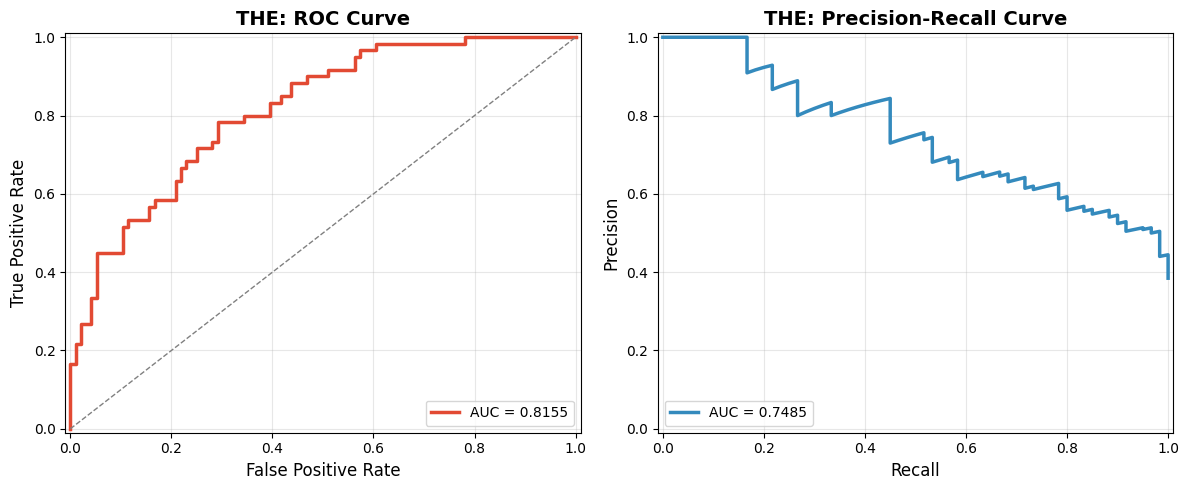

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score
)

def plot_roc_prc_curve(y_true, y_scores, title_prefix=''):
    """
    Plot aesthetically improved ROC and Precision-Recall curves with AUC scores.

    Args:
        y_true (array-like): Ground truth binary labels (0 or 1).
        y_scores (array-like): Predicted scores (e.g., probabilities).
        title_prefix (str): Optional prefix for plot titles.
    """
    # Use a clean style
    plt.style.use('seaborn-v0_8-muted')

    # Compute metrics
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = average_precision_score(y_true, y_scores)

    # Print AUC values
    print(f'{title_prefix}ROC-AUC: {roc_auc:.4f}')
    print(f'{title_prefix}PRC-AUC: {prc_auc:.4f}')

    # Set up plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='#E24A33', lw=2.5, label=f'AUC = {roc_auc:.4f}')
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    axes[0].set_xlim([-0.01, 1.01])
    axes[0].set_ylim([-0.01, 1.01])
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title(f'{title_prefix}ROC Curve', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(alpha=0.3)

    # PRC Curve
    axes[1].plot(recall, precision, color='#348ABD', lw=2.5, label=f'AUC = {prc_auc:.4f}')
    axes[1].set_xlim([-0.01, 1.01])
    axes[1].set_ylim([-0.01, 1.01])
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title(f'{title_prefix}Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_roc_prc_curve(AS_natural['label'], AS_natural['pred'], title_prefix='THE: ')

## Calculate precision score under different thresholds
This indicates when the model is highly confident in its predictions, it is more likely to be correct.

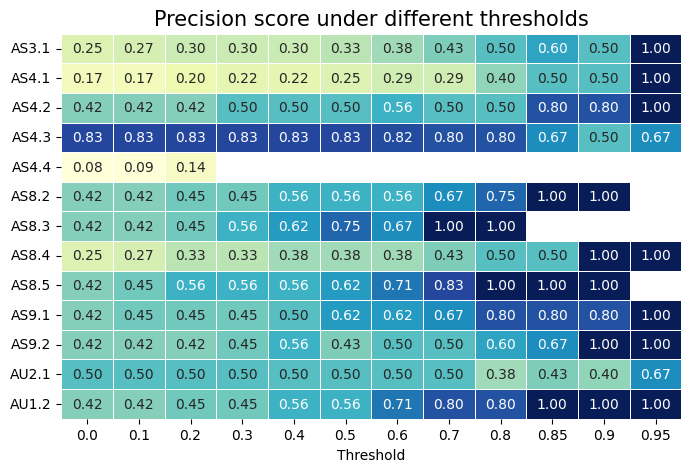

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
thresholds = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9, 0.95]
tcr_unique = AS_natural['Name'].value_counts().index.tolist()
precision_all = []
for tcr in tcr_unique:
    precision_list = []  
    for threshold in thresholds:
        df_baselines = AS_natural[AS_natural['Name'] == tcr]
        cm = confusion_matrix(df_baselines['label'].values, df_baselines['pred'].values > threshold)
        TP = cm[1, 1]
        FP = cm[0, 1]
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0 
        # precision = TP
        precision_list.append(precision)
    precision_all.append(precision_list)

# Create a DataFrame
df = pd.DataFrame(precision_all, columns=thresholds, index=tcr_unique)

# Create the heatmap
# if precision is 0, delete the value
df = df.replace(0, np.nan)
plt.figure(figsize=(8, 5))
sns.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5, cbar=False)
plt.xlabel('Threshold')
plt.title('Precision score under different thresholds', fontsize=15)
#hidden colorbar
plt.show()

## Visualize the attention weights for CDR3 regions

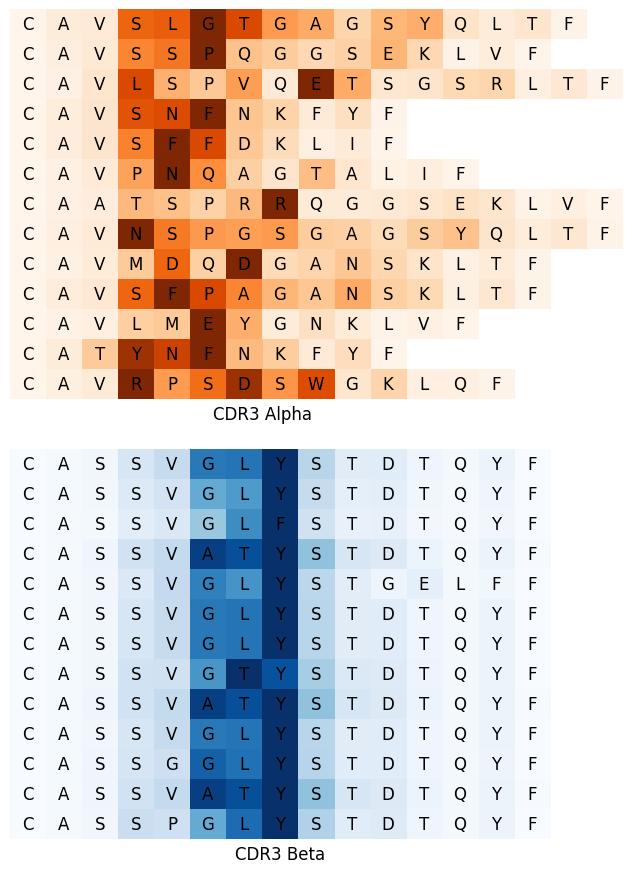

In [39]:
def find_alpha_region(seq):
    start = seq.find('CA')
    for tag in ['TF', 'IF', 'YF', 'VF', 'QF']:
        end = seq.find(tag)
        if end != -1:
            return start, end + 2
    return start, len(seq)

def find_beta_region(seq):
    start = seq.find('CA')
    for tag in ['TQYF', 'ELFF']:
        end = seq.find(tag)
        if end != -1:
            return start, end + len(tag)
    return start, len(seq)

def extract_cdr3_ab_pairs(alpha_seqs, beta_seqs, alpha_attn_tensor, beta_attn_tensor):
    out_alpha_seqs, out_alpha_attns = [], []
    out_beta_seqs, out_beta_attns = [], []

    for i in range(len(alpha_seqs)):
        a_start, a_end = find_alpha_region(alpha_seqs[i])
        b_start, b_end = find_beta_region(beta_seqs[i])
        if a_start != -1 and a_end > a_start and b_start != -1 and b_end > b_start:
            out_alpha_seqs.append(alpha_seqs[i][a_start:a_end])
            out_alpha_attns.append(alpha_attn_tensor[i][:, :, a_start:a_end])
            out_beta_seqs.append(beta_seqs[i][b_start:b_end])
            out_beta_attns.append(beta_attn_tensor[i][:, :, b_start:b_end])

    return out_alpha_seqs, out_alpha_attns, out_beta_seqs, out_beta_attns

def plot_cdr3_ab_attn_split(alpha_seq, alpha_attn, beta_seq, beta_attn, alpha_set, channels=(2,3,4,5,6,7)):

    max_len = max(
        max((len(seq) for seq in alpha_seq), default=1),
        max((len(seq) for seq in beta_seq), default=1)
    )

    width_per_aa = 0.4
    height_per_row = 0.3
    fig_height = len(alpha_set) * height_per_row * 2 + 1
    fig = plt.figure(figsize=(max_len * width_per_aa, fig_height))

    for i, seq in enumerate(alpha_set):
        idxs = [j for j, s in enumerate(alpha_seq) if s == seq]
        if not idxs:
            continue
        j = idxs[0]
        attn_a = alpha_attn[j][channels, :, :].sum((0, 1))  # shape: (seq_len,)
        attn_b = beta_attn[j][channels, :, :].sum((0, 1))
        seq_a = alpha_seq[j]
        seq_b = beta_seq[j]

        # --- alpha 行 ---
        ax1 = fig.add_axes([
            0.05,
            1 - (i + 1) * height_per_row / fig_height,
            len(seq_a) / max_len * 0.9,
            height_per_row / fig_height
        ])
        ax1.imshow(attn_a.unsqueeze(0).numpy(), aspect='auto', cmap='Oranges')
        for k, aa in enumerate(seq_a):
            ax1.text(k, 0, aa, ha='center', va='center', fontsize=12)
        ax1.set_xticks([]); ax1.set_yticks([])
        for spine in ax1.spines.values():
            spine.set_visible(False)
        ax1.set_xlabel('CDR3 Alpha', fontsize=12)

        # --- beta 行 ---
        ax2 = fig.add_axes([
            0.05,
            0.5 - (i + 1) * height_per_row / fig_height,
            len(seq_b) / max_len * 0.9,
            height_per_row / fig_height
        ])
        ax2.imshow(attn_b.unsqueeze(0).numpy(), aspect='auto', cmap='Blues')
        for k, bb in enumerate(seq_b):
            ax2.text(k, 0, bb, ha='center', va='center', fontsize=12)
        ax2.set_xticks([]); ax2.set_yticks([])
        for spine in ax2.spines.values():
            spine.set_visible(False)
        ax2.set_xlabel('CDR3 Beta', fontsize=12)

    plt.show()

pos_index = AS_natural[AS_natural['label'] == 1].index
alpha_seq = AS_natural.loc[pos_index, 'alpha'].values
beta_seq = AS_natural.loc[pos_index, 'beta'].values
alpha_attn_tensor = alpha_attn[pos_index]
beta_attn_tensor = beta_attn[pos_index]

alpha_seq, alpha_attn_cdr3, beta_seq, beta_attn_cdr3 = extract_cdr3_ab_pairs(
    alpha_seq, beta_seq, alpha_attn_tensor, beta_attn_tensor
)

alpha_set = [
    'CAVSLGTGAGSYQLTF','CAVSSPQGGSEKLVF','CAVLSPVQETSGSRLTF',
    'CAVSNFNKFYF','CAVSFFDKLIF','CAVPNQAGTALIF','CAATSPRRQGGSEKLVF',
    'CAVNSPGSGAGSYQLTF','CAVMDQDGANSKLTF','CAVSFPAGANSKLTF',
    'CAVLMEYGNKLVF','CATYNFNKFYF','CAVRPSDSWGKLQF'
]

plot_cdr3_ab_attn_split(alpha_seq, alpha_attn_cdr3, beta_seq, beta_attn_cdr3, alpha_set)